## 导入相关包 

In [1]:
import requests
import json
import re
from bs4 import BeautifulSoup
import time
import pymongo
import json
from matplotlib import pyplot as plt 


## 定义参数

In [2]:

#------- 不同平台属性的对应关系 ------#
elements_mapping = {
    '型号':'产品型号',
    '制冷功率（W）':'制冷功率(W)',
    '制冷功率':'制冷功率(W)',
    '制热量（W）':'制热量(W)',
    '制热功率（W）':'制热功率(W)',
    '制热功率':'制热功率(W)',
    '电辅加热功率（W）':'电辅加热功率(W)',
    '电辅加热':'电辅加热功率(W)',
    '匹数':'产品匹数',
    '制冷量（W）':'制冷量(W)',
    '室内机尺寸(宽x高x深)mm':'内机尺寸（宽x高x深）mm',
    '内机机身尺寸(宽x高x深)mm':'内机尺寸（宽x高x深）mm',
    '室外机尺寸(宽x高x深)mm':'外机尺寸（宽x高x深）mm',
    '外机机身尺寸(宽x高x深)mm':'外机尺寸（宽x高x深）mm',
    '变频/定频':'定频/变频',
    '适用面积':'适用面积（平方米）',
    '能效比':'能源消耗效率',
    '定频机能效比':'能源消耗效率',
    '变频机能效比':'能源消耗效率',
    '内机噪音 dB(A)':'内机噪音dB（A）',
    '内机噪音(dB(A)':'内机噪音dB（A）',
    '外机噪音 dB(A)':'外机噪音dB（A）',
    '外机噪音(dB(A)':'外机噪音dB（A）',
    '循环风量m³/h':'循环风量(m³/h)',
    '循环风量（m³/h）':'循环风量(m³/h)',
    '循环风量(m3/h)':'循环风量(m³/h)',
    '额定电压/频率（V/Hz）':'电压/频率（V/Hz）',
    '电压/频率':'电压/频率（V/Hz）'
}
#------- 不同平台属性的对应关系 ------#


#--------- 参数量化关系 --------------#
zlj_role = {'R32':1, 'R41a':0.75, '新冷媒（R410a）':0.75, 'R22':0.5} # 制冷剂 
lxdj_role = {'新一级能效':1,'一级能效':0.75,'二级能效':0.5,'三级能效':0.25} # 能效等级
ps_role = {'5匹':1,'4匹':0.9,'3匹':0.8,'2.5匹':0.7,'2匹':0.6,'1.5匹':0.5,'小1.5匹':0.4,'1.5匹':0.3,'大1匹':0.2,'1匹':0.1,'小1匹':0.0} # 匹数
bpdp_role = {'变频':1,'定频':0.5} # 变频定频 
#--------- 参数量化关系 ---------------#


#--------- 综合指数 --------------#
xishu = {"价格":2,"制热功率":1,"制冷功率":1,"能效等级":1,"制冷剂":1,"产品匹数":1,"变频/定频":1}
#--------- 综合指数 --------------#


#--------- 启动 mongodb 服务 ---------#
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
# mydb = myclient["jdtest"]
mydb = myclient["kongtiao"]
# mycol = mydb["sites0602"]
mycol = mydb["sites06012"]
#--------- 启动 mongodb 服务 ---------#

#--------- 获取页数 ------------#
begin_index = 1
end_index = 13
#--------- 获取页数 ------------#

## 定义不同的方法

In [3]:

'''
    获取产品简介元素（价格、优惠券、名字、地址）
'''
def get_good_des(dict_tmp,good): 
    try:
        dict_tmp['价格'] = float(str(good.select('div.jiaqian > strong')[0].string).replace('￥',''))

        dict_tmp['名字'] = str(good.select('div.n_font > p > a')[0]['title']).replace('\xa0','').replace('（','(').replace('）',')').strip()
#         print(dict_tmp['名字'])
        pattens_goods = '<a .*?href="(.*?)"'
        goods_url = re.findall(pattens_goods,str(good),re.S)
#         print(good)
        dict_tmp['地址'] = ('https://mall.gree.com/'+goods_url[0]).replace('amp;','')
        
    except:
        print("获取商品简介出错！")
        
'''
    获取商品详情元素
'''
def get_good_details(dict_tmp, html_good): 
    html_good = BeautifulSoup(html_good,'lxml')
    elements = str(html_good.select('#myTab0_Content1')[0])
    key = re.findall('cKey">(.*?):',elements,re.S)
    value = re.findall('</label>(.*?)<',elements,re.S)
#     print(len(key),len(value))
    for i in range(len(key)):
        tmp_key = key[i]
        if tmp_key in elements_mapping:
            tmp_key = elements_mapping[tmp_key]
        dict_tmp[tmp_key] = value[i].replace('\r\n','').strip()
    
'''
    访问产品详细界
'''
def get_good(url): 
#     print(url)
    request_data = requests.get(url)
    return request_data.text

"""
    数据库更新
"""
def upsert(mycol,data):
    if '地址' in data:
        mycol.update_one(
            {'地址':data['地址']},
            {'$set':data},
            upsert=True
        )
    else:
        print("更新数据错误！")

## 获取商品

In [4]:
for index in range(begin_index,end_index):
    print(index)
    form_data = {
        'page':index,
        'cid':849,
        'orderSort':0
    }
    request_data = requests.post('https://mall.gree.com/goods/search/searchItem',data=form_data)
    html_list = request_data.text
    soup = BeautifulSoup(html_list,'lxml')
    goods = soup.select('#right > div.Search_list > div')
    x = 0
    print('完成 ',((index-begin_index)/(end_index-begin_index))*100,'%')
    for good in goods:
        
        
        dict_tmp = {}    
#         print((good))
        get_good_des(dict_tmp,good)
        get_good_details(dict_tmp,get_good(dict_tmp["地址"]))
        upsert(mycol,dict_tmp)
        
        print(x,dict_tmp["地址"])
        
        x = x + 1   
print('完成 100 %')

1
完成  0.0 %
0 https://mall.gree.com//goods/product/details?id=1002973198&skuId=1000302727
1 https://mall.gree.com//goods/product/details?id=1002979470&skuId=1000309259
2 https://mall.gree.com//goods/product/details?id=1002979469&skuId=1000309258
3 https://mall.gree.com//goods/product/details?id=1002979482&skuId=1000309271
4 https://mall.gree.com//goods/product/details?id=1002973197&skuId=1000302726
5 https://mall.gree.com//goods/product/details?id=1002973196&skuId=1000302725
6 https://mall.gree.com//goods/product/details?id=1001001469&skuId=1000079097
7 https://mall.gree.com//goods/product/details?id=1002979483&skuId=1000309272
8 https://mall.gree.com//goods/product/details?id=1002973194&skuId=1000302723
9 https://mall.gree.com//goods/product/details?id=1002941931&skuId=1000270727
10 https://mall.gree.com//goods/product/details?id=1002979821&skuId=1000309681
11 https://mall.gree.com//goods/product/details?id=1002979820&skuId=1000309680
12 https://mall.gree.com//goods/product/details?id

20 https://mall.gree.com//goods/product/details?id=1002950321&skuId=1000279127
21 https://mall.gree.com//goods/product/details?id=1002978426&skuId=1000308191
22 https://mall.gree.com//goods/product/details?id=1002961104&skuId=1000290124
23 https://mall.gree.com//goods/product/details?id=1002977550&skuId=1000307183
24 https://mall.gree.com//goods/product/details?id=1002963576&skuId=1000292724
25 https://mall.gree.com//goods/product/details?id=1002963579&skuId=1000292727
26 https://mall.gree.com//goods/product/details?id=1002979484&skuId=1000309273
27 https://mall.gree.com//goods/product/details?id=1000270404&skuId=1000056682
5
完成  33.33333333333333 %
0 https://mall.gree.com//goods/product/details?id=1002961913&skuId=1000290984
1 https://mall.gree.com//goods/product/details?id=1002974687&skuId=1000304240
2 https://mall.gree.com//goods/product/details?id=1000025756&skuId=1000042611
3 https://mall.gree.com//goods/product/details?id=1002950317&skuId=1000279123
4 https://mall.gree.com//goods

204 43
地址
产品匹数
价格
内机噪音dB（A）
内机尺寸（宽x高x深）mm
内机装箱清单
内机质量（kg）
制冷剂
制冷功率(W)
制冷量(W)
制热功率(W)
制热量(W)
单冷/冷暖
名字
品牌
外机噪音dB（A）
外机尺寸（宽x高x深）mm 
外机装箱清单
外机质量（kg）
定频/变频
循环风量(m³/h)
挂机/柜机
是否电辅加热
电压/频率（V/Hz）
电辅加热功率(W)
能效等级
能源消耗效率
适用面积（平方米）
颜色
制冷/制热额定功率（W）
制冷/制热额定电流（A）
噪声（声压级）（dB（A））
整机尺寸（宽x高x深）mm
最大制冷/制热输入功率（W）
最大制冷/制热输入电流（A）
质量（kg）
额定电压(V)
额定频率(Hz)
功能
噪音（室内/室外）dB(A)
外机尺寸（宽x高x深）mm
防水等级
面板尺寸(宽x高x深)mm


c:\users\180801\appdata\local\programs\python\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 179 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\180801\appdata\local\programs\python\python36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 179 missing from current font.
  font.set_text(s, 0, flags=flags)


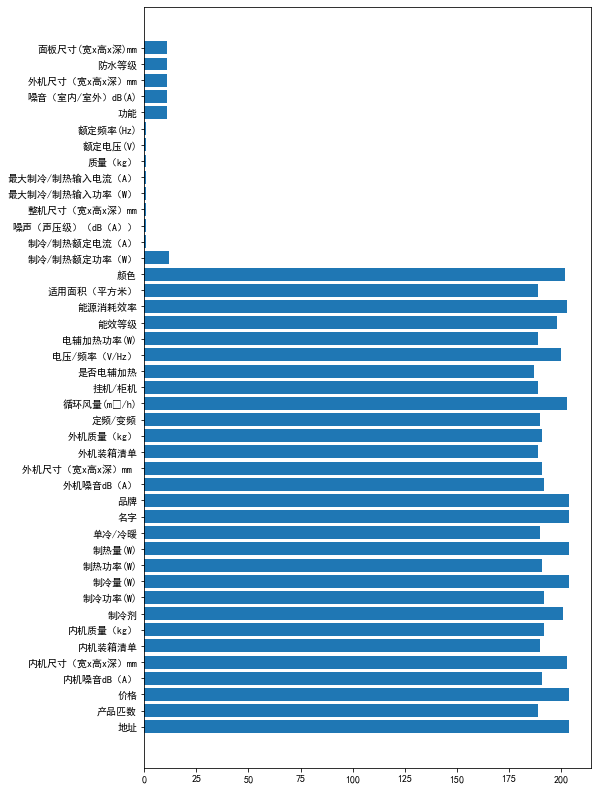

In [5]:
res = mycol.find({},{"_id":0}).sort("价格")

i = 0
key_dict = {}
    
i = 0
for x in res:
#     print(i,x)
    i = i + 1
    
    for m in x:
        if(m in key_dict):
            key_dict[m] = key_dict[m] + 1
        else:
            key_dict[m] = 1
print(i, len(key_dict))

label = []
nums = []
for m in key_dict:
    print(m)
    label.append(m)
    nums.append(key_dict[m])
plt.figure(figsize = (8,14))
plt.rcParams['font.sans-serif']=['SimHei']

plt.barh(label,nums)
# plt.xticks(label, label, rotation=-90)
plt.show()

In [11]:
import pandas as pd
res = mycol.find({},{"_id":0})
key_dict = {}
    
i = 0
for x in res:
#     print(i,x)
    i = i + 1
    
    for m in x:
        if(m in key_dict):
            key_dict[m] = key_dict[m] + 1
        else:
            key_dict[m] = 1
        print(m,type(x[m]))
    break

# print(len(key_dict))
# for m in key_dict:
#     print(m,'->\t',key_dict[m])


地址 <class 'str'>
产品匹数 <class 'str'>
价格 <class 'float'>
内机噪音dB（A） <class 'str'>
内机尺寸（宽x高x深）mm <class 'str'>
内机装箱清单 <class 'str'>
内机质量（kg） <class 'str'>
制冷剂 <class 'str'>
制冷功率(W) <class 'str'>
制冷量(W) <class 'str'>
制热功率(W) <class 'str'>
制热量(W) <class 'str'>
单冷/冷暖 <class 'str'>
名字 <class 'str'>
品牌 <class 'str'>
外机噪音dB（A） <class 'str'>
外机尺寸（宽x高x深）mm  <class 'str'>
外机装箱清单 <class 'str'>
外机质量（kg） <class 'str'>
定频/变频 <class 'str'>
循环风量(m³/h) <class 'str'>
挂机/柜机 <class 'str'>
是否电辅加热 <class 'str'>
电压/频率（V/Hz） <class 'str'>
电辅加热功率(W) <class 'str'>
能效等级 <class 'str'>
能源消耗效率 <class 'str'>
适用面积（平方米） <class 'str'>
颜色 <class 'str'>


In [6]:

res = mycol.find({},{"_id":0})
key_dict = {}
    
i = 0
for x in res:
#     print(i,x)
    i = i + 1
    
    for m in x:
        if(m in key_dict):
            key_dict[m] = key_dict[m] + 1
        else:
            key_dict[m] = 1

print(len(key_dict))
for m in key_dict:
    print(m,'->\t',key_dict[m])

43
地址 ->	 204
产品匹数 ->	 189
价格 ->	 204
内机噪音dB（A） ->	 191
内机尺寸（宽x高x深）mm ->	 203
内机装箱清单 ->	 190
内机质量（kg） ->	 192
制冷剂 ->	 201
制冷功率(W) ->	 192
制冷量(W) ->	 204
制热功率(W) ->	 191
制热量(W) ->	 204
单冷/冷暖 ->	 190
名字 ->	 204
品牌 ->	 204
外机噪音dB（A） ->	 192
外机尺寸（宽x高x深）mm  ->	 191
外机装箱清单 ->	 189
外机质量（kg） ->	 191
定频/变频 ->	 190
循环风量(m³/h) ->	 203
挂机/柜机 ->	 189
是否电辅加热 ->	 187
电压/频率（V/Hz） ->	 200
电辅加热功率(W) ->	 189
能效等级 ->	 198
能源消耗效率 ->	 203
适用面积（平方米） ->	 189
颜色 ->	 202
制冷/制热额定功率（W） ->	 12
制冷/制热额定电流（A） ->	 1
噪声（声压级）（dB（A）） ->	 1
整机尺寸（宽x高x深）mm ->	 1
最大制冷/制热输入功率（W） ->	 1
最大制冷/制热输入电流（A） ->	 1
质量（kg） ->	 1
额定电压(V) ->	 1
额定频率(Hz) ->	 1
功能 ->	 11
噪音（室内/室外）dB(A) ->	 11
外机尺寸（宽x高x深）mm ->	 11
防水等级 ->	 11
面板尺寸(宽x高x深)mm ->	 11


## 数据清洗 
### 能级等级

In [8]:
res = mycol.find({},{"_id":0})
nx_map = {'3级':'三级能效','2级':'二级能效','1级':'新一级能效'}
i = 0
for x in res:
    i = i + 1
    myquery = { "地址": x["地址"] }
    if "能效等级" in x:
        print(x["能效等级"])
        if x["能效等级"] in nx_map:
            x["能效等级"] = nx_map[x["能效等级"]]
        newvalues = { "$set": {"能效等级": x["能效等级"]}}
        mycol.update_one(myquery, newvalues)
i


新一级能效
新一级能效
新一级能效
三级能效
新一级能效
三级能效
三级能效
三级能效
三级能效
三级能效
三级能效
三级能效
新一级能效
二级能效
新一级能效
三级能效
三级能效
三级能效
三级能效
新一级能效
新一级能效
三级能效
新一级能效
三级能效
新一级能效
二级能效
新一级能效
三级能效
三级能效
新一级能效
三级能效
新一级能效
新一级能效
二级能效
新一级能效
新一级能效
三级能效
新一级能效
三级能效
新一级能效
新一级能效
三级能效
三级能效
新一级能效
三级能效
新一级能效
新一级能效
三级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
二级能效
新一级能效
三级能效
新一级能效
三级能效
三级能效
三级能效
新一级能效
二级能效
三级能效
三级能效
三级能效
新一级能效
二级能效
新一级能效
三级能效
三级能效
新一级能效
新一级能效
二级能效
三级能效
新一级能效
新一级能效
二级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
三级能效
三级能效
新一级能效
三级能效
三级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
三级能效
新一级能效
新一级能效
新一级能效
新一级能效
三级能效
新一级能效
新一级能效
新一级能效
二级能效
新一级能效
三级能效
新一级能效
三级能效
新一级能效
新一级能效
二级能效
二级能效
新一级能效
新一级能效
三级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
三级能效
新一级能效
新一级能效
二级能效
二级能效
新一级能效
新一级能效
新一级能效
三级能效
新一级能效
新一级能效
新一级能效
三级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
二级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
三级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
新一级能效
二级能效
新一级能效
三级能效
二级能效
新一级能效
新一级能效
二级能效
二级能效
二级能效
新一级能效
三级能效

204

In [9]:
res = mycol.find({"地址":{"$regex":"https:"}},{"_id":0}).sort("价格")
tmp_Str = 'https://mall.gree.com/'
res = mycol.find({"$or":[{'地址':{ "$regex": tmp_Str}}]},{"_id":0}).sort("价格")

i = 0
key_dict = {}
    
i = 0
for x in res:
    print(i,x["地址"])
    i = i + 1
    
    

0 https://mall.gree.com//goods/product/details?id=1000270404&skuId=1000056682
1 https://mall.gree.com//goods/product/details?id=1002973194&skuId=1000302723
2 https://mall.gree.com//goods/product/details?id=1001001469&skuId=1000079097
3 https://mall.gree.com//goods/product/details?id=1002973196&skuId=1000302725
4 https://mall.gree.com//goods/product/details?id=1002973197&skuId=1000302726
5 https://mall.gree.com//goods/product/details?id=1002973198&skuId=1000302727
6 https://mall.gree.com//goods/product/details?id=1002979482&skuId=1000309271
7 https://mall.gree.com//goods/product/details?id=1002979469&skuId=1000309258
8 https://mall.gree.com//goods/product/details?id=1002979362&skuId=1000309141
9 https://mall.gree.com//goods/product/details?id=1002978426&skuId=1000308191
10 https://mall.gree.com//goods/product/details?id=1002979483&skuId=1000309272
11 https://mall.gree.com//goods/product/details?id=1002972179&skuId=1000301650
12 https://mall.gree.com//goods/product/details?id=1002938209&

## 数据清洗 
### 名字去特殊字符

In [13]:
res = mycol.find({},{"_id":0}).sort("价格")
i = 0
for x in res:    
    tmp = x["名字"].replace('（','(').replace('）',')').replace('/','').replace('-','').replace('(WIFI)','').replace('(wifi)','').replace('(TM)','').replace('(JD)','')
    i = i + 1 
    myquery = { "地址": x["地址"] }
    newvalues = { "$set": { "名字": tmp } }
    if "产品型号" in x:
        newvalues["$set"]["产品型号"] = x["产品型号"].replace('（','(').replace('）',')').replace('/','').replace('-','').strip()
    mycol.update_one(myquery, newvalues)
print(i)

4664


In [62]:
pattens = '[A-Za-z0-9]{7}'

tmps = '【新国标】格力・玫瑰变频冷暖大1匹1级能效挂机空调 KFR26GW(26588)FNhAaB1(花瓣粉)【新国标】格力•玫瑰变频冷暖3匹1级能效柜机空调 KFR72LW(72501)FNhAaB1(WIFI)(花瓣粉) 【新国标】京淳变频冷暖3匹1级能效柜机空调 KFR72LWNhDj1BGj(碧玺蓝)【新国标】天井机5匹变频冷暖2级能效 380V电源 KFR120TW(12550S)FNhCaB2'

s = re.findall(pattens,tmps)
print(s)


['KFR26GW', 'FNhAaB1', 'KFR72LW', 'FNhAaB1', 'KFR72LW', 'NhDj1BG', 'KFR120T', 'FNhCaB2']


In [12]:
res = mycol.find({},{"_id":0})
i = 0
for x in res:    
    print(x)
    i = i + 1
    if i == 10:
        break

{'地址': 'https://mall.gree.com//goods/product/details?id=1002973198&skuId=1000302727', '产品匹数': '正1.5匹', '价格': 2899.0, '内机噪音dB（A）': '高风挡35', '内机尺寸（宽x高x深）mm': '825x293x196', '内机装箱清单': '室内机*1、遥控器*1、电池*2、说明书*2', '内机质量（kg）': '9.5', '制冷剂': 'R32', '制冷功率(W)': '810(75-2030)', '制冷量(W)': '3510(150-5210)', '制热功率(W)': '1250(90-2200)', '制热量(W)': '5010(150-6770)', '单冷/冷暖': '冷暖', '名字': '【新国标】天丽变频冷暖正1.5匹1级能效挂机空调 KFR35GW(35530)FNhAkB1(皓雪白)', '品牌': '格力', '外机噪音dB（A）': '51', '外机尺寸（宽x高x深）mm ': '802x555x350', '外机装箱清单': '室外机*1、连接管部件*1', '外机质量（kg）': '27.5', '定频/变频': '变频', '循环风量(m³/h)': '710', '挂机/柜机': '挂机', '是否电辅加热': '是', '电压/频率（V/Hz）': '220V～/50Hz', '电辅加热功率(W)': '1000', '能效等级': '新一级能效', '能源消耗效率': '5.27(全年能源消耗效率）', '适用面积（平方米）': '16-20', '颜色': '皓雪白'}
{'地址': 'https://mall.gree.com//goods/product/details?id=1002979470&skuId=1000309259', '产品匹数': '正1.5匹', '价格': 3199.0, '内机噪音dB（A）': '高风挡35', '内机尺寸（宽x高x深）mm': '825x293x196', '内机装箱清单': '室内机*1、遥控器*1、电池*2、说明书*2', '内机质量（kg）': '9.5', '制冷剂': 'R32', '制冷功率(W)': '810(75～2030)',